Import použitých knižníc

In [974]:
# Tieto importy treba na final verziu zjednotit
import pandas as pd
from pandas.tseries.offsets import BMonthEnd, BDay
import numpy as np
import glob, os

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

import mplfinance as fplt

import seaborn as sns

In [972]:
files = glob.glob('InputData/*.csv')
df = pd.concat([pd.read_csv(fp, parse_dates=True).assign(Title=os.path.basename(fp).split('.')[0]) 
       for fp in files])

df['Date'] = pd.to_datetime(df['Date'])

# Create a new column 'is_last_day' to identify the last day of the month
df['IsLastDayOfMnth'] = df['Date'].dt.is_month_end

# set the index
df.set_index('Date', inplace=True)

df.rename(columns={'Adj Close':'AdjClose'}, inplace=True)

# Use the BMonthEnd offset to find the last business day of each month
LastBusinessDay = df.groupby(pd.Grouper(freq='M')).apply(lambda x: x.index + BMonthEnd())

# Add a boolean column indicating if the date is the last business day
df['LastBusinessDay'] = df.index.isin(LastBusinessDay)

# Calculate daily returns. Calculate from CLOSE price (not form Adj. Close). Create separate column.
#df['RDaily'] = df.Close / df.Open - 1
df['RDaily'] = df.groupby('Title')['Close'].pct_change(1) # 1 for ONE DAY lookback

# Sort the DataFrame by a specific column and index
#df = df.sort_values(by='Title', ascending=True).sort_index(ascending=True)

print (df.head())
#print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
#print(df.info())

                 Open       High        Low      Close   AdjClose    Volume  \
Date                                                                          
2018-04-18  47.910000  48.310001  47.840000  48.139999  43.171364  80289500   
2018-04-19  48.259998  48.290001  47.700001  47.860001  42.920261  67581100   
2018-04-20  47.590000  47.619999  47.049999  47.259998  42.382191  80997700   
2018-04-23  47.169998  47.299999  46.779999  46.880001  42.041412  74337500   
2018-04-24  47.259998  47.360001  46.430000  46.660000  41.844120  72196800   

           Title  IsLastDayOfMnth  LastBusinessDay    RDaily  
Date                                                          
2018-04-18   EEM            False            False       NaN  
2018-04-19   EEM            False            False -0.005816  
2018-04-20   EEM            False            False -0.012537  
2018-04-23   EEM            False            False -0.008041  
2018-04-24   EEM            False            False -0.004693  


In [967]:
DistinctTitles=df['Title'].unique()

SelectTitle=widgets.ToggleButtons(
    options=DistinctTitles,
    description='Title:',
    disabled=False,
    button_style=''
)

def DistinctTitlePlot(SelectTitle):
    fplt.plot(  df[df['Title'] == SelectTitle],
            type='candle',
            style='charles',
            title=SelectTitle,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            warn_too_much_data=99999999
            )

   
out1 = widgets.interactive_output(DistinctTitlePlot, {'SelectTitle': SelectTitle})

display(SelectTitle)
display(out1)

ToggleButtons(description='Title:', options=('EEM', 'GLD', 'SPY', 'TLT', 'VGK'), value='EEM')

Output()

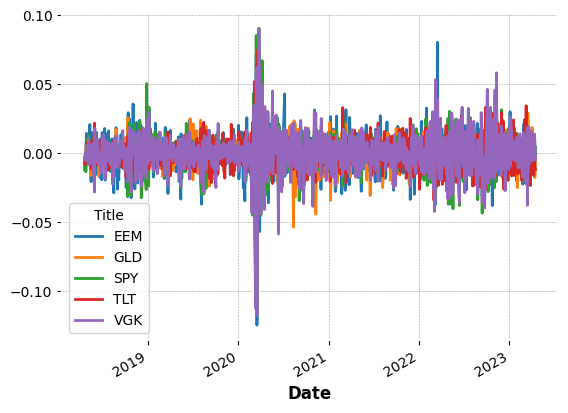

In [973]:
df.pivot(columns="Title", values="RDaily").plot()

plt.show()

In [975]:
# Initialize an empty list to store the values
tmp = []

grouped_df = df.groupby(['Title', df.index.year, df.index.month])

for (title, year, month), group in grouped_df:
    std_value = group['RDaily'].std()
    inv_std_value = 1/group['RDaily'].std()
    tmp.append([title, year, month, std_value, inv_std_value])

# Create a new DataFrame from the collected data
df_mthly = pd.DataFrame(tmp, columns=['Title', 'Year', 'Month', 'StdValue', 'InvStdVal'])

# Print the result DataFrame
print(df_mthly.head())

  Title  Year  Month  StdValue   InvStdVal
0   EEM  2018      4  0.008913  112.190082
1   EEM  2018      5  0.010344   96.671045
2   EEM  2018      6  0.011167   89.552675
3   EEM  2018      7  0.010631   94.062919
4   EEM  2018      8  0.013460   74.295834


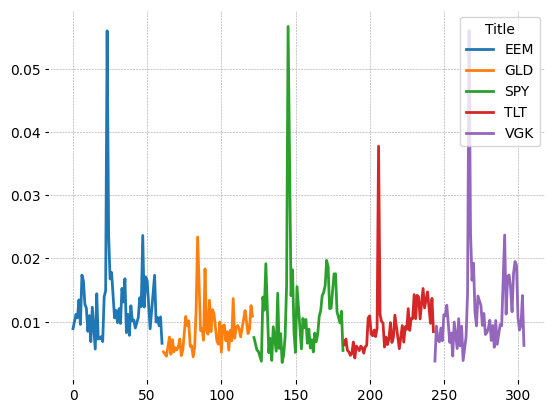

In [976]:
df_mthly.pivot(columns="Title", values="StdValue").plot()

plt.show()

# MODEL 1

In [977]:
# # Calculate the actual value of the position for each title

# #df['ValueOfPosition'] = 
# df.groupby('Title')['RDaily'].apply(lambda x: (1 + x).cumprod())



# # Calculate the actual value of the position for each title
# new_column = df.groupby('Title')['RDaily'].apply(lambda x: (1 + x).cumprod())

# df['Value'] = new_column.reset_index(level=0, drop=True)


# # Identify the first day of each month
# #month_starts = df.resample('M').max().index
# month_starts = df.groupby(pd.Grouper(freq='M')).max().index


# # Initialize the weights and portfolio value
# weights = None
# portfolio_value = 100



# month_starts['Date'] = pd.to_datetime(month_starts['Date']).dt.date

# df['Date'] = pd.to_datetime(df['Date']).dt.date



In [978]:
df_mthly_pivot = df_mthly.pivot(index=['Year','Month'], columns="Title", values="InvStdVal")
df_mthly_pivot['Sum_InvStdVal'] = df_mthly_pivot['EEM'] + df_mthly_pivot['GLD'] + df_mthly_pivot['SPY'] + df_mthly_pivot['TLT'] + df_mthly_pivot['VGK']

df_mthly_pivot['W_EEM'] = df_mthly_pivot['EEM'] / df_mthly_pivot['Sum_InvStdVal']
df_mthly_pivot['W_GLD'] = df_mthly_pivot['GLD'] / df_mthly_pivot['Sum_InvStdVal']
df_mthly_pivot['W_SPY'] = df_mthly_pivot['SPY'] / df_mthly_pivot['Sum_InvStdVal']
df_mthly_pivot['W_TLT'] = df_mthly_pivot['TLT'] / df_mthly_pivot['Sum_InvStdVal']
df_mthly_pivot['W_VGK'] = df_mthly_pivot['VGK'] / df_mthly_pivot['Sum_InvStdVal']

df_mthly_pivot['W_CHECK_SUM'] = df_mthly_pivot['W_EEM'] + df_mthly_pivot['W_GLD'] + df_mthly_pivot['W_SPY'] + df_mthly_pivot['W_TLT'] + df_mthly_pivot['W_VGK']

df_mthly_pivot.head()

Title              EEM         GLD         SPY         TLT         VGK  \
Year Month                                                               
2018 4      112.190082  191.254343  133.229333  157.160708  264.177029   
     5       96.671045  205.094445  153.006459  137.590558  107.405124   
     6       89.552675  219.817050  181.220823  182.094913  140.420290   
     7       94.062919  174.027304  188.482820  190.867584  146.646743   
     8       74.295834  131.857257  227.992675  213.152283  111.100826   

Title       Sum_InvStdVal     W_EEM     W_GLD     W_SPY     W_TLT     W_VGK  \
Year Month                                                                    
2018 4         858.011495  0.130756  0.222904  0.155277  0.183169  0.307895   
     5         699.767631  0.138147  0.293089  0.218653  0.196623  0.153487   
     6         813.105750  0.110137  0.270343  0.222875  0.223950  0.172696   
     7         794.087369  0.118454  0.219154  0.237358  0.240361  0.184673   
     8         758.398874  0.097964  0.173863  0.300624  0.281056  0.146494   

Title       W_CHECK_SUM  
Year Month               
2018 4              1.0  
     5              1.0  
     6              1.0  
     7              1.0  
     8              1.0

In [979]:
df_mthly_unpivot = df_mthly_pivot.stack(level=(0)).reset_index()

df_mthly_unpivot = df_mthly_unpivot[df_mthly_unpivot["Title"].isin(["W_EEM", "W_GLD", 'W_SPY', 'W_TLT', 'W_VGK'])].copy()

df_mthly_unpivot.columns.values[-1] = "W"

df_mthly_unpivot['Title'] = df_mthly_unpivot['Title'].str.replace('W_', '')

df_mthly_unpivot.head(5)

,Year,Month,Title,W
6,2018,4,EEM,0.130756
7,2018,4,GLD,0.222904
8,2018,4,SPY,0.155277
9,2018,4,TLT,0.183169
10,2018,4,VGK,0.307895


In [991]:
# na df leftjoinovat df_mthly_unpivot dla index.year, index.mont a Title
df['Title'] = df['Title'].astype(str)
df_mthly_unpivot['Title'] = df_mthly_unpivot['Title'].astype(str)

df_comp = pd.merge(df.reset_index(), df_mthly_unpivot.reset_index(), how='left', 
                   left_on=[df.reset_index()['Date'].dt.year, df.reset_index()['Date'].dt.month, 'Title'], 
                   right_on=['Year', 'Month', 'Title'])

In [992]:
# Convert the "Date" column to datetime if it's not already
df_comp['Date'] = pd.to_datetime(df_comp['Date'])

# Extract year and month from the "Date" column
df_comp['Year'] = df_comp['Date'].dt.year
df_comp['Month'] = df_comp['Date'].dt.month

# Find the maximum and minimum date for each year and month
min_max_dates = df_comp.groupby(['Year', 'Month'])['Date'].agg([min, max]).reset_index()

# Merge the min and max dates back to the original DataFrame
df_comp = pd.merge(df_comp, min_max_dates, on=['Year', 'Month'], how='left')

df_comp.head()

,Date,Open,High,Low,Close,AdjClose,Volume,Title,IsLastDayOfMnth,LastBusinessDay,RDaily,index,Year,Month,W,min,max
0,2018-04-18,47.910000,48.310001,47.840000,48.139999,43.171364,80289500,EEM,False,False,NaN,6,2018,4,0.130756,2018-04-18,2018-04-30
1,2018-04-19,48.259998,48.290001,47.700001,47.860001,42.920261,67581100,EEM,False,False,-0.005816,6,2018,4,0.130756,2018-04-18,2018-04-30
2,2018-04-20,47.590000,47.619999,47.049999,47.259998,42.382191,80997700,EEM,False,False,-0.012537,6,2018,4,0.130756,2018-04-18,2018-04-30
3,2018-04-23,47.169998,47.299999,46.779999,46.880001,42.041412,74337500,EEM,False,False,-0.008041,6,2018,4,0.130756,2018-04-18,2018-04-30
4,2018-04-24,47.259998,47.360001,46.430000,46.660000,41.844120,72196800,EEM,False,False,-0.004693,6,2018,4,0.130756,2018-04-18,2018-04-30


In [1014]:
# Perform the pivot operation
result = df_comp.pivot(index=['Date', 'Year', 'Month'], columns='Title', values=['RDaily', 'W'])

# Flatten the column names
result.columns = ['{}_{}'.format(col[1], col[0]) for col in result.columns]

# Reset the index
result = result.reset_index()

# Print the result
#print(result)

# Concatenate the 'Date', 'Year', 'Month' columns from the original dataframe with the 'result' dataframe
new_df_comp = pd.concat([df_comp[['Date', 'Year','Month','min','max', ]], result], axis=1)

#new_df_comp.drop(new_df_comp.iloc[:, 0:1],axis = 1, inplace=True)

new_df_comp = new_df_comp[new_df_comp['EEM_W'].notna()]

new_df_comp.head()


,Date,Year,Month,min,max,Date,Year,Month,EEM_RDaily,GLD_RDaily,SPY_RDaily,TLT_RDaily,VGK_RDaily,EEM_W,GLD_W,SPY_W,TLT_W,VGK_W
0,2018-04-18,2018,4,2018-04-18,2018-04-30,2018-04-18,2018.0,4.0,NaN,NaN,NaN,NaN,NaN,0.130756,0.222904,0.155277,0.183169,0.307895
1,2018-04-19,2018,4,2018-04-18,2018-04-30,2018-04-19,2018.0,4.0,-0.005816,-0.001955,-0.005548,-0.008146,-0.002820,0.130756,0.222904,0.155277,0.183169,0.307895
2,2018-04-20,2018,4,2018-04-18,2018-04-30,2018-04-20,2018.0,4.0,-0.012537,-0.007602,-0.008479,-0.007208,-0.004325,0.130756,0.222904,0.155277,0.183169,0.307895
3,2018-04-23,2018,4,2018-04-18,2018-04-30,2018-04-23,2018.0,4.0,-0.008041,-0.007976,-0.000150,0.000253,0.000167,0.130756,0.222904,0.155277,0.183169,0.307895
4,2018-04-24,2018,4,2018-04-18,2018-04-30,2018-04-24,2018.0,4.0,-0.004693,0.004856,-0.013467,-0.004557,-0.005346,0.130756,0.222904,0.155277,0.183169,0.307895


In [1015]:
def remove_dup_columns(frame):
     keep_names = set()
     keep_icols = list()
     for icol, name in enumerate(frame.columns):
          if name not in keep_names:
               keep_names.add(name)
               keep_icols.append(icol)
     return frame.iloc[:, keep_icols]



new_df_comp = remove_dup_columns(new_df_comp)

In [1016]:
new_df_comp['Date'].iloc[0] == new_df_comp['min'].iloc[0]

True

In [1017]:
new_df_comp.head()

,Date,Year,Month,min,max,EEM_RDaily,GLD_RDaily,SPY_RDaily,TLT_RDaily,VGK_RDaily,EEM_W,GLD_W,SPY_W,TLT_W,VGK_W
0,2018-04-18,2018,4,2018-04-18,2018-04-30,NaN,NaN,NaN,NaN,NaN,0.130756,0.222904,0.155277,0.183169,0.307895
1,2018-04-19,2018,4,2018-04-18,2018-04-30,-0.005816,-0.001955,-0.005548,-0.008146,-0.002820,0.130756,0.222904,0.155277,0.183169,0.307895
2,2018-04-20,2018,4,2018-04-18,2018-04-30,-0.012537,-0.007602,-0.008479,-0.007208,-0.004325,0.130756,0.222904,0.155277,0.183169,0.307895
3,2018-04-23,2018,4,2018-04-18,2018-04-30,-0.008041,-0.007976,-0.000150,0.000253,0.000167,0.130756,0.222904,0.155277,0.183169,0.307895
4,2018-04-24,2018,4,2018-04-18,2018-04-30,-0.004693,0.004856,-0.013467,-0.004557,-0.005346,0.130756,0.222904,0.155277,0.183169,0.307895


<Axes: xlabel='Date', ylabel='SUM_all_pos_value'>

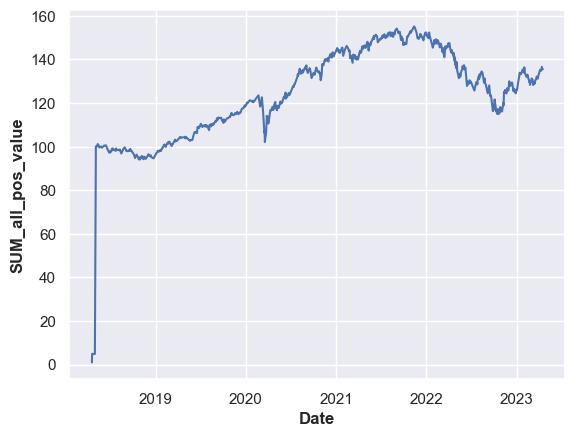

In [1018]:
new_df_comp['CHECK'] = 'check'

new_df_comp['EEM_pos_value'] = 1
new_df_comp['GLD_pos_value'] = 1
new_df_comp['SPY_pos_value'] = 1
new_df_comp['TLT_pos_value'] = 1
new_df_comp['VGK_pos_value'] = 1

new_df_comp['SUM_all_pos_value'] = 1
#new_df_comp['SUM_all_pos_value'].iloc[0] = 1

initial_capital = 100 # Initial capital invested at start of first year, second month

#cond_year = new_df_comp.loc[i, 'Date'].year == np.sort(new_df_comp['Date'].dt.year.unique())[0] # condition for first year of dataframe
#cond_month = new_df_comp.loc[i, 'Date'].month ==  np.sort(new_df_comp.loc[(new_df_comp['Date'].dt.year == np.sort(new_df_comp['Date'].dt.year.unique())[0])]['Date'].dt.month.unique())[1] # second month of first year in dataframe

for i in range(1, len(new_df_comp)):
    if ((new_df_comp.loc[i, 'Date'] == new_df_comp.loc[i, 'min']) & (new_df_comp.loc[i, 'Date'].year == np.sort(new_df_comp['Date'].dt.year.unique())[0]) & (new_df_comp.loc[i, 'Date'].month ==  np.sort(new_df_comp.loc[(new_df_comp['Date'].dt.year == np.sort(new_df_comp['Date'].dt.year.unique())[0])]['Date'].dt.month.unique())[1])): # ak sme na zaciatku mesiaca >>> tuna chceme rebalancovat ak sme na zaciatku druheho mesiaca prveho roku >>>tu rebalancujeme startovaci kapital 100 usd
        new_df_comp.loc[i, 'EEM_pos_value'] = initial_capital*new_df_comp.loc[i, 'EEM_W']*(1+new_df_comp.loc[i, 'EEM_RDaily'])
        new_df_comp.loc[i, 'GLD_pos_value'] = initial_capital*new_df_comp.loc[i, 'GLD_W']*(1+new_df_comp.loc[i, 'GLD_RDaily'])
        new_df_comp.loc[i, 'SPY_pos_value'] = initial_capital*new_df_comp.loc[i, 'SPY_W']*(1+new_df_comp.loc[i, 'SPY_RDaily'])
        new_df_comp.loc[i, 'TLT_pos_value'] = initial_capital*new_df_comp.loc[i, 'TLT_W']*(1+new_df_comp.loc[i, 'TLT_RDaily'])
        new_df_comp.loc[i, 'VGK_pos_value'] = initial_capital*new_df_comp.loc[i, 'VGK_W']*(1+new_df_comp.loc[i, 'VGK_RDaily'])

        new_df_comp.loc[i, 'CHECK']  = 'First year Second month start'

        new_df_comp.loc[i, 'SUM_all_pos_value'] = new_df_comp.loc[i, 'EEM_pos_value']+new_df_comp.loc[i, 'GLD_pos_value']+new_df_comp.loc[i, 'SPY_pos_value']+new_df_comp.loc[i, 'TLT_pos_value']+new_df_comp.loc[i, 'VGK_pos_value']

    elif ((new_df_comp.loc[i, 'Date'] == new_df_comp.loc[i, 'min'])):
        new_df_comp.loc[i, 'EEM_pos_value'] = new_df_comp.loc[i-1, 'SUM_all_pos_value']*new_df_comp.loc[i, 'EEM_W']*(1+new_df_comp.loc[i, 'EEM_RDaily'])
        new_df_comp.loc[i, 'GLD_pos_value'] = new_df_comp.loc[i-1, 'SUM_all_pos_value']*new_df_comp.loc[i, 'GLD_W']*(1+new_df_comp.loc[i, 'GLD_RDaily'])
        new_df_comp.loc[i, 'SPY_pos_value'] = new_df_comp.loc[i-1, 'SUM_all_pos_value']*new_df_comp.loc[i, 'SPY_W']*(1+new_df_comp.loc[i, 'SPY_RDaily'])
        new_df_comp.loc[i, 'TLT_pos_value'] = new_df_comp.loc[i-1, 'SUM_all_pos_value']*new_df_comp.loc[i, 'TLT_W']*(1+new_df_comp.loc[i, 'TLT_RDaily'])
        new_df_comp.loc[i, 'VGK_pos_value'] = new_df_comp.loc[i-1, 'SUM_all_pos_value']*new_df_comp.loc[i, 'VGK_W']*(1+new_df_comp.loc[i, 'VGK_RDaily'])

        new_df_comp.loc[i, 'CHECK']  = 'Start of month'

        new_df_comp.loc[i, 'SUM_all_pos_value'] = new_df_comp.loc[i, 'EEM_pos_value']+new_df_comp.loc[i, 'GLD_pos_value']+new_df_comp.loc[i, 'SPY_pos_value']+new_df_comp.loc[i, 'TLT_pos_value']+new_df_comp.loc[i, 'VGK_pos_value']

    else:
        new_df_comp.loc[i, 'EEM_pos_value'] = new_df_comp.loc[i-1, 'EEM_pos_value']*(1+new_df_comp.loc[i, 'EEM_RDaily'])
        new_df_comp.loc[i, 'GLD_pos_value'] = new_df_comp.loc[i-1, 'GLD_pos_value']*(1+new_df_comp.loc[i, 'GLD_RDaily'])
        new_df_comp.loc[i, 'SPY_pos_value'] = new_df_comp.loc[i-1, 'SPY_pos_value']*(1+new_df_comp.loc[i, 'SPY_RDaily'])
        new_df_comp.loc[i, 'TLT_pos_value'] = new_df_comp.loc[i-1, 'TLT_pos_value']*(1+new_df_comp.loc[i, 'TLT_RDaily'])
        new_df_comp.loc[i, 'VGK_pos_value'] = new_df_comp.loc[i-1, 'VGK_pos_value']*(1+new_df_comp.loc[i, 'VGK_RDaily'])
        #new_df_comp.loc[i, 'VGK_pos_value'] = 100010000

        new_df_comp.loc[i, 'CHECK']  = '*-*-*-*-*-*-*-*-*-*'

        new_df_comp.loc[i, 'SUM_all_pos_value'] = new_df_comp.loc[i, 'EEM_pos_value']+new_df_comp.loc[i, 'GLD_pos_value']+new_df_comp.loc[i, 'SPY_pos_value']+new_df_comp.loc[i, 'TLT_pos_value']+new_df_comp.loc[i, 'VGK_pos_value']



import seaborn as sns
sns.lineplot(data=new_df_comp, x="Date", y="SUM_all_pos_value")

In [1019]:
new_df_comp.head(10)

,Date,Year,Month,min,max,EEM_RDaily,GLD_RDaily,SPY_RDaily,TLT_RDaily,VGK_RDaily,...,SPY_W,TLT_W,VGK_W,CHECK,EEM_pos_value,GLD_pos_value,SPY_pos_value,TLT_pos_value,VGK_pos_value,SUM_all_pos_value
0,2018-04-18,2018,4,2018-04-18,2018-04-30,NaN,NaN,NaN,NaN,NaN,...,0.155277,0.183169,0.307895,check,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2018-04-19,2018,4,2018-04-18,2018-04-30,-0.005816,-0.001955,-0.005548,-0.008146,-0.002820,...,0.155277,0.183169,0.307895,*-*-*-*-*-*-*-*-*-*,0.994184,0.998045,0.994452,0.991854,0.997180,4.975714
2,2018-04-20,2018,4,2018-04-18,2018-04-30,-0.012537,-0.007602,-0.008479,-0.007208,-0.004325,...,0.155277,0.183169,0.307895,*-*-*-*-*-*-*-*-*-*,0.981720,0.990458,0.986020,0.984705,0.992867,4.935769
3,2018-04-23,2018,4,2018-04-18,2018-04-30,-0.008041,-0.007976,-0.000150,0.000253,0.000167,...,0.155277,0.183169,0.307895,*-*-*-*-*-*-*-*-*-*,0.973826,0.982558,0.985872,0.984954,0.993033,4.920243
4,2018-04-24,2018,4,2018-04-18,2018-04-30,-0.004693,0.004856,-0.013467,-0.004557,-0.005346,...,0.155277,0.183169,0.307895,*-*-*-*-*-*-*-*-*-*,0.969256,0.987329,0.972595,0.980465,0.987724,4.897370
5,2018-04-25,2018,4,2018-04-18,2018-04-30,-0.007715,-0.006496,0.002472,-0.006698,-0.004031,...,0.155277,0.183169,0.307895,*-*-*-*-*-*-*-*-*-*,0.961778,0.980915,0.974999,0.973899,0.983743,4.875333
6,2018-04-26,2018,4,2018-04-18,2018-04-30,0.014471,-0.003509,0.010166,0.006999,0.005565,...,0.155277,0.183169,0.307895,*-*-*-*-*-*-*-*-*-*,0.975696,0.977474,0.984911,0.980715,0.989217,4.908012
7,2018-04-27,2018,4,2018-04-18,2018-04-30,0.006174,0.004241,0.000939,0.007713,0.001006,...,0.155277,0.183169,0.307895,*-*-*-*-*-*-*-*-*-*,0.981720,0.981619,0.985835,0.988279,0.990212,4.927666
8,2018-04-30,2018,4,2018-04-18,2018-04-30,-0.007194,-0.007251,-0.007691,0.001766,-0.004858,...,0.155277,0.183169,0.307895,*-*-*-*-*-*-*-*-*-*,0.974657,0.974501,0.978254,0.990025,0.985402,4.902839
9,2018-05-01,2018,5,2018-05-01,2018-05-31,-0.004902,-0.007063,0.001777,-0.005793,-0.005556,...,0.218653,0.196623,0.153487,First year Second month start,13.747016,29.101923,21.904176,19.548409,15.263413,99.564937


## CAGR of this portfolio between 2020-01-01 and 2022-12-31

In [1059]:
# Filter the DataFrame for a specific year
year_first = 2020
first_date = df[df.index.year == year_first].index[0]

year_last = 2022
last_date = df[df.index.year == year_last].index[-1]

CAGR = (new_df_comp.loc[(new_df_comp['Date'] == last_date)]['SUM_all_pos_value'].values[0] / new_df_comp.loc[(new_df_comp['Date'] == first_date)]['SUM_all_pos_value'].values[0])**(1/3)-1

print ('Portfolio had a CAGR of {:.2%} '.format(CAGR))

Portfolio had a CAGR of 1.49% 
